In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.2.0-rc1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import BinaryAccuracy
from PIL import Image

from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import notebook

### Đọc dữ liệu

In [ ]:
im_height = 512
im_width = 512

In [ ]:
import os
ids = next(os.walk("/content/drive/MyDrive/KLTN/data_unet/train_isbi/image"))[2] # list of names all images in the given path
print("Số lượng ảnh = ", len(ids))

Số lượng ảnh =  90


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = np.array(Image.open("/content/drive/MyDrive/KLTN/data_unet/train_isbi/image/"+id_).convert('L'))
    x_img = resize(img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = np.array(Image.open("/content/drive/MyDrive/KLTN/data_unet/train_isbi/label/"+id_).convert('L'))
    x_mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = x_mask/255.0

In [ ]:
# import cv2
# import glob

# ext = ['png', 'jpg', 'jpeg', 'tif']

# files = []
# files_masks = []

# [files.extend(glob.glob('/content/drive/MyDrive/KLTN/data_unet/Salt/train/images/*.' + e)) for e in ext]
# [files_masks.extend(glob.glob('/content/drive/MyDrive/KLTN/data_unet/Salt/train/masks/*.' + e)) for e in ext]

# X = np.zeros((len(files), im_height, im_width, 1), dtype=np.float32)
# y = np.zeros((len(files), im_height, im_width, 1), dtype=np.float32)

# for i in range(len(files)):
#     img = np.array(Image.open(files[i]).convert('L'))
#     x_img = resize(img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

#     # Load masks
#     mask = np.array(Image.open(files_masks[i]).convert('L'))
#     x_mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

#     # Save images
#     X[i] = x_img/255
#     y[i] = x_mask/255

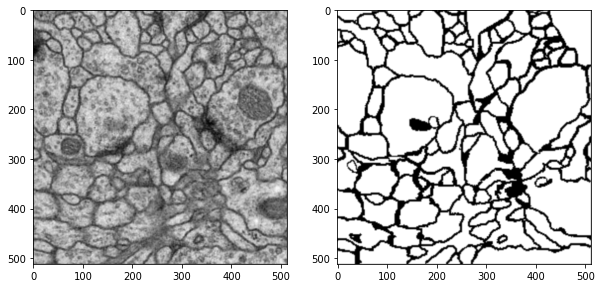

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(X[0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.imshow(y[0].squeeze(), cmap = 'gray', interpolation = 'bilinear')

In [ ]:
# chia dữ liệu thành 2 phần 80-20
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print("X train: ", len(X_train))
print("y train: ", len(y_train))
print("X valid: ", len(X_valid))
print(X_train[1].shape)
print(y_train[1].shape)
print(type(X_train[0][0][0][0]))

X train:  72
y train:  72
X valid:  18
(512, 512, 1)
(512, 512, 1)
<class 'numpy.float32'>


### Định nghĩa khối 2 lớp convolution

In [ ]:
# Định nghĩa khối gồm 2 lớp conv2d sửa dụng BatchNormalization và relu
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # Lớp thứ nhất
    x1 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    
    # Lớp thứ 2
    x2 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x1)
    if batchnorm:
        x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    return x2

### Định nghĩa mô hình mạng U-net

In [ ]:
def unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    # contraction (encode)
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck 
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # expansion (decode)
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [ ]:
# test new optimizer function
!pip install adabelief-tf==0.2.0
from adabelief_tf import AdaBeliefOptimizer

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')

model = unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
# model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer = AdaBeliefOptimizer(learning_rate=0.001, epsilon=1e-12, rectify=False, print_change_log = False), loss="binary_crossentropy", metrics=[BinaryAccuracy()])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Đào tạo mô hình

In [ ]:
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/KLTN/model_save/model_isbi.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=18, epochs=250, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/250
4/4 [==============================] - 55s 1s/step - loss: 0.7362 - binary_accuracy: 0.5062 - val_loss: 0.6721 - val_binary_accuracy: 0.7124

Epoch 00001: val_binary_accuracy improved from -inf to 0.71240, saving model to /content/drive/MyDrive/KLTN/model_save/model_isbi.h5
Epoch 2/250
4/4 [==============================] - 4s 950ms/step - loss: 0.5299 - binary_accuracy: 0.6898 - val_loss: 0.6354 - val_binary_accuracy: 0.7181

Epoch 00002: val_binary_accuracy improved from 0.71240 to 0.71812, saving model to /content/drive/MyDrive/KLTN/model_save/model_isbi.h5
Epoch 3/250
4/4 [==============================] - 4s 955ms/step - loss: 0.4729 - binary_accuracy: 0.7316 - val_loss: 0.6205 - val_binary_accuracy: 0.7185

Epoch 00003: val_binary_accuracy improved from 0.71812 to 0.71850, saving model to /content/drive/MyDrive/KLTN/model_save/model_isbi.h5
Epoch 4/250
4/4 [==============================] - 4s 960ms/step - loss: 0.4253 - binary_accuracy: 0.7603 - val_loss: 0.5774 - va

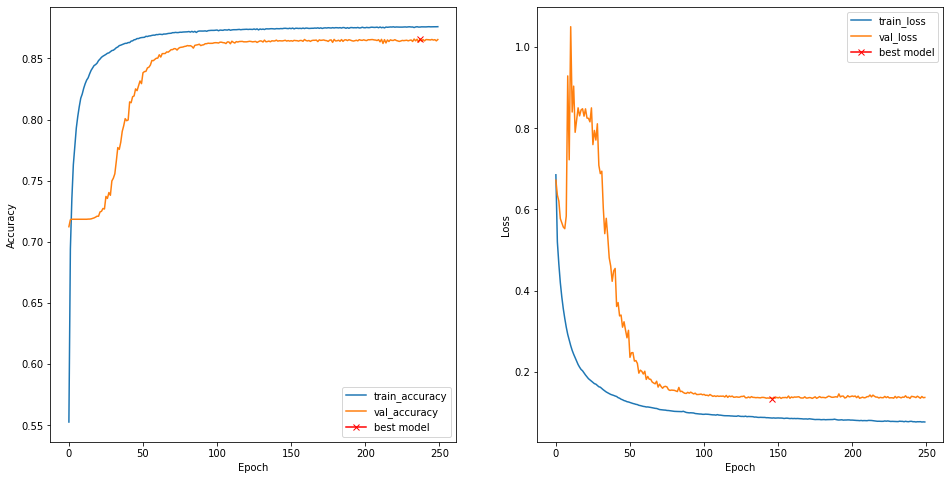

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.plot(results.history['binary_accuracy'], label='train_accuracy')
plt.plot(results.history['val_binary_accuracy'], label = 'val_accuracy')
plt.plot(np.argmax(results.history["val_binary_accuracy"]), np.max(results.history["val_binary_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(1,2,2)
plt.plot(results.history['loss'], label='train_loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# weight tốt nhất
model.load_weights('/content/drive/MyDrive/KLTN/model_save/model_isbi.h5')

# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/KLTN/model_save/model_salf.h5', compile=False)

In [ ]:
# Độ chính xác trên tập valid
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 1s 667ms/step - loss: 0.1363 - binary_accuracy: 0.8660


[0.1363200545310974, 0.8660032749176025]

### Thử nghiệm mô hình

1/1 [==============================] - 0s 284ms/step


Text(0.5, 1.0, 'predict binary')

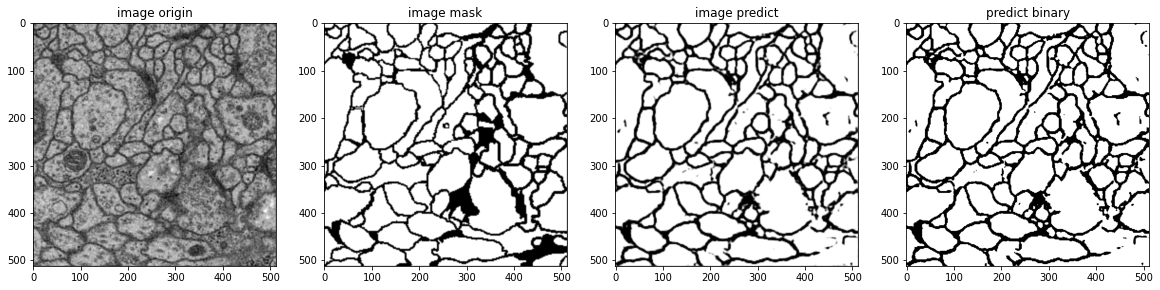

In [ ]:
import random
idx_rd = random.randint(0, len(X_valid)-1)

pred_img = model.predict(X_valid, verbose=1)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))

ax[0].imshow(X_valid[idx_rd].squeeze(), cmap='gray')
ax[0].set_title('image origin')

ax[1].imshow(y_valid[idx_rd].squeeze(), cmap='gray')
ax[1].set_title('image mask')

ax[2].imshow(pred_img[idx_rd].squeeze(), cmap='gray')
ax[2].set_title('image predict')

pred_bn = (pred_img[idx_rd] > 0.5).astype(np.uint8)

ax[3].imshow(pred_bn.squeeze(), cmap='gray')
ax[3].set_title('predict binary')

1/1 [==============================] - 43s 43s/step


Text(0.5, 1.0, 'predict binary')

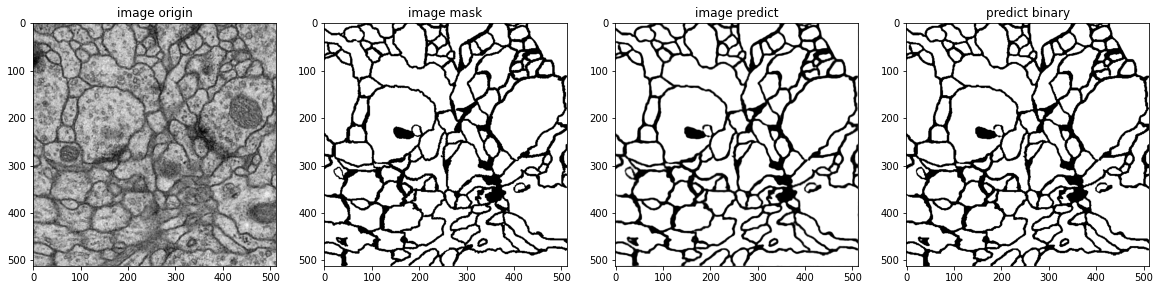

In [ ]:
img_test = np.array(Image.open('/content/drive/MyDrive/KLTN/data_unet/train_isbi/train-volume.tif').convert('L'))
img_test = resize(img_test, (512, 512, 1), mode = 'constant', preserve_range = True)

mask_test = np.array(Image.open('/content/drive/MyDrive/KLTN/data_unet/train_isbi/train-labels.tif').convert('L'))
mask_test = resize(mask_test, (512, 512, 1), mode = 'constant', preserve_range = True)

arr_img = [img_test]
arr_img = np.array(arr_img)/255

# predict
pred_img_test = model.predict(arr_img, verbose=1)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(img_test.squeeze(), cmap='gray')
ax[0].set_title('image origin')

ax[1].imshow(mask_test.squeeze(), cmap='gray')
ax[1].set_title('image mask')

ax[2].imshow(pred_img_test[0].squeeze(), cmap='gray')
ax[2].set_title('image predict')

pred_bn_test = (pred_img_test[0] > 0.5).astype(np.uint8)
ax[3].imshow(pred_bn_test.squeeze(), cmap='gray')
ax[3].set_title('predict binary')